In [1]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(0, os.path.abspath(os.pardir))
import CONFIG
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [4]:
tf.__version__

'2.3.0'

In [5]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [6]:
ROOT = CONFIG.CFG.DATA.BASE
BATCH_SIZE=128

In [7]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")

add infos


In [ ]:
tr.head()

In [8]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [9]:
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

In [10]:
sub.head()

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker


In [17]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [18]:
tr.sample(15)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE
1171,ID00323637202285211956970,29,1550,64.929625,77,Male,Ex-smoker,train
76,ID00020637202178344345685,31,2115,108.439295,66,Female,Never smoked,train
322,ID00090637202204766623410,73,2907,77.577925,69,Male,Ex-smoker,train
1052,ID00288637202279148973731,34,2365,81.879241,63,Female,Ex-smoker,train
1369,ID00376637202297677828573,77,4251,118.743017,72,Male,Never smoked,train
936,ID00241637202264294508775,40,1290,72.749831,66,Female,Never smoked,train
767,ID00202637202249376026949,75,3646,90.732630,64,Male,Never smoked,train
1517,ID00421637202311550012437,23,2853,85.460101,68,Male,Ex-smoker,train
976,ID00255637202267923028520,7,1498,62.188642,62,Female,Never smoked,train
1209,ID00336637202286801879145,20,2545,64.620150,56,Male,Ex-smoker,train


In [19]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [20]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [21]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [22]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [23]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [24]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [25]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [26]:
FE

['Male',
 'Female',
 'Ex-smoker',
 'Never smoked',
 'Currently smokes',
 'age',
 'percent',
 'week',
 'BASE']

In [27]:
tr.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0,1,0,1,0,0,0.769231,0.241456,0.179012,0.236393
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0,1,0,1,0,0,0.769231,0.241456,0.234568,0.215941
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,11.0,1,0,1,0,0,0.769231,0.241456,0.246914,0.184960
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,13.0,1,0,1,0,0,0.769231,0.241456,0.259259,0.201767
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,15.0,1,0,1,0,0,0.769231,0.241456,0.271605,0.186580


In [28]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,6.0,3020,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,6.0,3020,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,6.0,3020,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,6.0,3020,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,6.0,3020,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [16]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [63]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return -K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [64]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [65]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [66]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)

In [68]:
%%time
cnt = 0
EPOCHS = 900
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [36.522621154785156, -6.499330043792725]
val [41.43809127807617, -6.530084133148193]
predict val...
predict test...
FOLD 2
train [38.4687385559082, -6.543188571929932]
val [42.897216796875, -6.621898651123047]
predict val...
predict test...
FOLD 3
train [33.91835403442383, -6.386788368225098]
val [52.70643997192383, -6.735795497894287]
predict val...
predict test...
FOLD 4
train [39.739559173583984, -6.560006618499756]
val [39.41019058227539, -6.531267166137695]
predict val...
predict test...
FOLD 5
train [34.813236236572266, -6.417832851409912]
val [50.27983474731445, -6.804264545440674]
predict val...
predict test...
CPU times: user 4min 32s, sys: 30.3 s, total: 5min 3s
Wall time: 3min 36s


In [47]:
# mean absolute error of the predictions for train pred[:, 1] gives q50(median)
sigma_opt = mean_absolute_error(y, pred[:, 1])
# uncertainty? (q75 - q25)?
unc = pred[:,2] - pred[:, 0]
# mean_uncertainty?
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

139.3734912984146 233.86445396000866


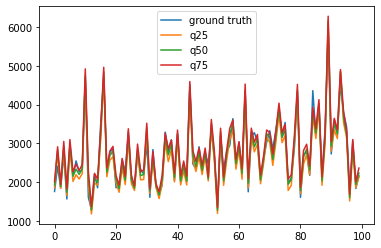

In [48]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [24]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

0.0 0.0 0.0 1.0


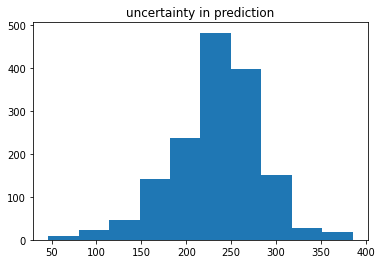

In [49]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [51]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,6.0,3020,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,6.0,3020,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,6.0,3020,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,6.0,3020,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,6.0,3020,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [60]:
sub['FVC1'] = 0.996*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [61]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [62]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2849.341651,244.976562
1541,ID00419637202311204720264_-11,3020,100.0,2846.925451,245.861450
1542,ID00419637202311204720264_-10,3020,100.0,2844.509069,246.746643
1543,ID00419637202311204720264_-9,3020,100.0,2842.092869,247.631592
1544,ID00419637202311204720264_-8,3020,100.0,2839.676609,248.516357
1545,ID00419637202311204720264_-7,3020,100.0,2837.260470,249.401489
1546,ID00419637202311204720264_-6,3020,100.0,2834.844392,250.286316
1547,ID00419637202311204720264_-5,3020,100.0,2832.428192,251.171326
1548,ID00419637202311204720264_-4,3020,100.0,2830.011932,252.056274
1549,ID00419637202311204720264_-3,3020,100.0,2827.608863,252.939697


In [55]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [56]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2849.341651,244.976562,2849.341651,244.976562
1541,ID00419637202311204720264_-11,2846.925451,245.861450,2846.925451,245.861450
1542,ID00419637202311204720264_-10,2844.509069,246.746643,2844.509069,246.746643
1543,ID00419637202311204720264_-9,2842.092869,247.631592,2842.092869,247.631592
1544,ID00419637202311204720264_-8,2839.676609,248.516357,2839.676609,248.516357


In [32]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
Confidence,730.0,2692.054723,1.001130e-11,2692.054723,2692.054723,2692.054723,2692.054723,2692.054723
FVC1,730.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
Confidence1,730.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

FileNotFoundError: [Errno 2] File ../input/osic-pulmonary-fibrosis-progression/test.csv does not exist: '../input/osic-pulmonary-fibrosis-progression/test.csv'

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)